In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)

# 그래디언 기록 제어

In [3]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
    x_sq = x*x
    with t.stop_recording():
        y_sq = y*y
    z = x_sq + y_sq
grad = t.gradient(z, {"x":x, "y":y})
print("dz/dx : ", grad["x"])
print("dz/dy : ", grad["y"])

dz/dx :  tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy :  None


In [6]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


In [9]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


# 사용자 정의 그래디언트

In [16]:
@tf.custom_gradient
def clip_gradients(y):
    def backward(dy):
        return tf.clip_by_norm(dy, 0.5)
    return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
    output = clip_gradients(v * v)
    print(output)
print(t.gradient(output,v))

tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


# 다중 테이프

In [22]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)

In [23]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

1.0

In [24]:
tape1.gradient(ys, x1).numpy()   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25

0.25

# 고계도 그래디언트

In [25]:
x = tf.Variable(1.0)
with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


# 야고비안

In [28]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)
with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)
dy_dx = tape.jacobian(y, delta)

In [29]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


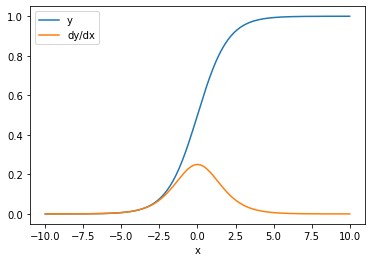

In [35]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

In [51]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

print(x.shape)
print(y.shape)
print(layer.kernel.shape)
j = tape.jacobian(y, layer.kernel)
j.shape

(7, 5)
(7, 10)
(5, 10)


TensorShape([7, 10, 5, 10])

In [53]:
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
# print("j_sum : ",j_sum)
print('delta:', delta)

g.shape: (5, 10)
delta: 2.3841858e-07
